In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython import display
from PIL import Image, ImageDraw

from opticaltomography.forward_inner import PhaseObject3D, Multislice
from opticaltomography.loss import mse_loss, sparsity_loss, total_variation_loss
# from opticaltomography.utils import showimgstack

In [2]:
path = "Dataset/fpbase_spectra.csv"
with open(path, encoding='utf-8') as f:
    egfp_em = np.loadtxt(path, dtype=str, delimiter=',', skiprows=1, usecols=(0,2,1,3))

In [3]:
egfp_em.shape

(796, 4)

In [4]:
type(egfp_em)

numpy.ndarray

In [5]:
# Units in microns
# objective immersion media
n_measure = 1.33
# background refractive index, PDMS
n_b = 1.33
mag = 20  
pixel_size = 4
na = 0.6
dx = pixel_size / mag
dy = dx
dz = dx * 3

wl_list = egfp_em[193:250,0].astype(np.float32)/1e3              # fluorescence wavelength/um
wl_em_coef_list = np.sqrt(egfp_em[193:250,1].astype(np.float32))      # fluorescence emission/um

dtype = torch.float32
np_dtype = np.float32

na_list = sio.loadmat("na_list_3D_rand_10.mat")
fx_illu_list = na_list["na_list_3D_rand"][:, 0] * 0.5   #paraxial condition
fy_illu_list = na_list["na_list_3D_rand"][:, 1] * 0.5
fz_illu_list = na_list["na_list_3D_rand"][:, 2] * 0     #z layer at the z=0

forward_field_mb = torch.zeros(len(wl_list), len(fx_illu_list), 200, 200)

for wl_num in range(len(wl_list)):
    # initial object, type: torch.float32
    # phantom = torch.zeros((200, 200, 25), dtype=dtype)
    phantom = torch.zeros((200, 200, 25), dtype=dtype)

    # ---------------------------#
    # Setup solver objects
    # ---------------------------#
    wavelength = wl_list[wl_num]
    solver_params = dict(wavelength = wavelength, na = na, \
                         RI_measure = n_measure, sigma = 2 * np.pi * dz / wavelength,\
                         fx_illu_list = fx_illu_list, fy_illu_list = fy_illu_list, fz_illu_list = fz_illu_list, \
                         voxel_size=(dy,dx,dz), pad = False, pad_size=(50,50))
    phase_obj_3d = PhaseObject3D(shape=phantom.shape, voxel_size=(dy,dx,dz), RI=n_b)
    solver_obj = Multislice(phase_obj_3d=phase_obj_3d, **solver_params)
    solver_obj.setScatteringMethod(model="MultiPhaseContrast")  # solver.obj._x set to zero

    # ---------------------------#
    # Fill in phantom
    # ---------------------------#
    # import the ground truth of the 3D object to generate forward measurements
    phantom_coordinates = sio.loadmat("phantomPoisson_nooverlap.mat")
    phantom_temp = phantom_coordinates["phantomPoisson"]
    solver_obj._x[50:150, 50:150, :] = torch.from_numpy(phantom_temp) * 0.1


    # Shift object
    for i in range(25):
        solver_obj._x[:,:,i] = torch.fft.ifftshift(solver_obj._x[:,:,i])
    
    # ---------------------------#
    # Generate forward prediction
    # ---------------------------#
    forward_field_mb[wl_num,:], fields = solver_obj.forward(obj=solver_obj._x, wl_coef=wl_em_coef_list[wl_num])

# Affect of spectrum

In [6]:
wl_em_coef_list

array([0.57576036, 0.60942596, 0.6445929 , 0.67808557, 0.7133022 ,
       0.74793047, 0.781281  , 0.815414  , 0.8474668 , 0.87555695,
       0.90338254, 0.92854726, 0.95010525, 0.9672125 , 0.9830565 ,
       0.993831  , 0.99969995, 0.99995   , 1.        , 0.99443454,
       0.9846827 , 0.96984535, 0.95184034, 0.9333274 , 0.9135097 ,
       0.89073   , 0.86654484, 0.8455176 , 0.8247424 , 0.8064738 ,
       0.7879086 , 0.7723988 , 0.754851  , 0.73959446, 0.72629195,
       0.71302176, 0.7       , 0.687968  , 0.6808818 , 0.67111844,
       0.6627971 , 0.6554388 , 0.64969224, 0.6407027 , 0.6335614 ,
       0.6278535 , 0.6218521 , 0.617252  , 0.6077006 , 0.60174745,
       0.5985817 , 0.5895761 , 0.5824946 , 0.5740209 , 0.5677147 ,
       0.5585696 , 0.54909015], dtype=float32)

interactive(children=(IntSlider(value=0, description='i', max=56), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames(i)>

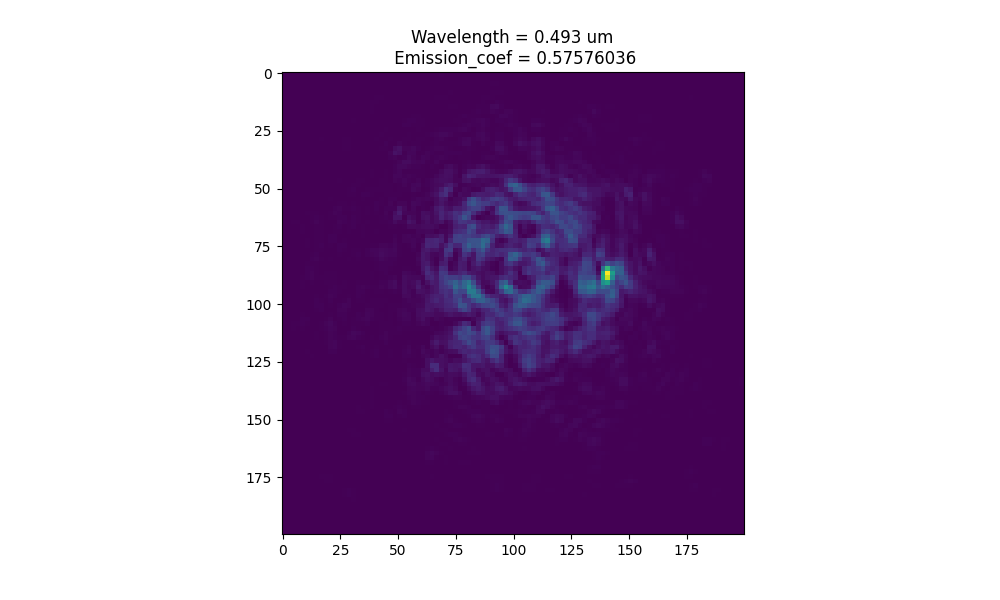

In [7]:
# ---------------------------#
# Show forward prediction
# ---------------------------#

# Show forward
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

def init():
    # img = torch.fft.fftshift(torch.abs(solver_obj.test[0]))
    # frames.append(axes.imshow(torch.abs(solver_obj.test_spherical[0])))
    frames.append(axes.imshow(forward_field_mb[0,0,:,:]))
    axes.set_title('Wavelength = '+str(wl_list[0])+' um\n Emission_coef = '+str(wl_em_coef_list[0]))

init()

def updateFrames(i):
    # img = torch.fft.fftshift(torch.abs(solver_obj.test_spherical[i]))
    #frames.append(axes.imshow(img))
    frames[0].set_data(torch.fft.fftshift(forward_field_mb[i,0,:,:])[50:150,50:150])
    axes.set_title('Wavelength = '+str(wl_list[i])+' um\n Emission_coef = '+str(wl_em_coef_list[i]))

interact(updateFrames, i=IntSlider(min=0, max=len(wl_em_coef_list)-1, step=1, value=0))

57
57


interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<function __main__.updateFrames(i)>

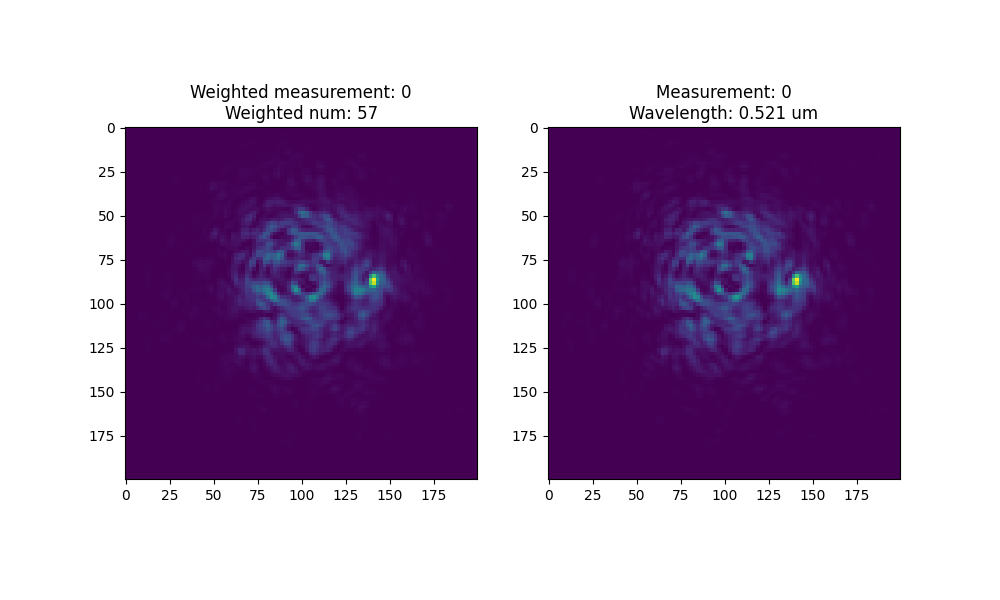

In [8]:
wl_len = len(wl_list)
print(wl_len)
weighted_len = 57
print(weighted_len)
start_point = wl_len//2 - weighted_len//2
end_point = start_point + weighted_len

forward_weighted_field = forward_field_mb[start_point:end_point,:,:,:]
forward_weighted_field_output = torch.sum(forward_weighted_field,0)

forward_field_mb = forward_field_mb/torch.max(forward_field_mb)
forward_weighted_field_output = forward_weighted_field_output/torch.max(forward_weighted_field_output)
# forward_weighted_field_output.shape

# ---------------------------#
# Show forward prediction
# ---------------------------#
# Show forward
f, axes = plt.subplots(1, 2, figsize=(10, 6))
frames = []

wl_num = wl_len//2

def init():
    # img = torch.fft.fftshift(torch.abs(solver_obj.test[0]))
    # frames.append(axes.imshow(torch.abs(solver_obj.test_spherical[0])))
    frames.append(axes[0].imshow(forward_weighted_field_output[0,:,:]))
    frames.append(axes[1].imshow(forward_field_mb[wl_num,0,:,:]))
    axes[0].set_title('Weighted measurement: 0 '+'\n'+'Weighted num: '+str(weighted_len))
    axes[1].set_title('Measurement: 0\n'+'Wavelength: '+str(wl_list[wl_num])+' um')

init()

def updateFrames(i):
    frames[0].set_data(torch.fft.fftshift(forward_weighted_field_output[i,:,:])[50:150,50:150])
    frames[1].set_data(torch.fft.fftshift(forward_field_mb[wl_num,i,:,:])[50:150,50:150])
    axes[0].set_title('Weighted measurement: '+str(i)+'\n'+'Weighted num: '+str(weighted_len))
    axes[1].set_title('Measurement: '+str(i)+'\n'+'Wavelength: '+str(wl_list[wl_num])+' um')

interact(updateFrames, i=IntSlider(min=0, max=9, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<function __main__.updateFrames(i)>

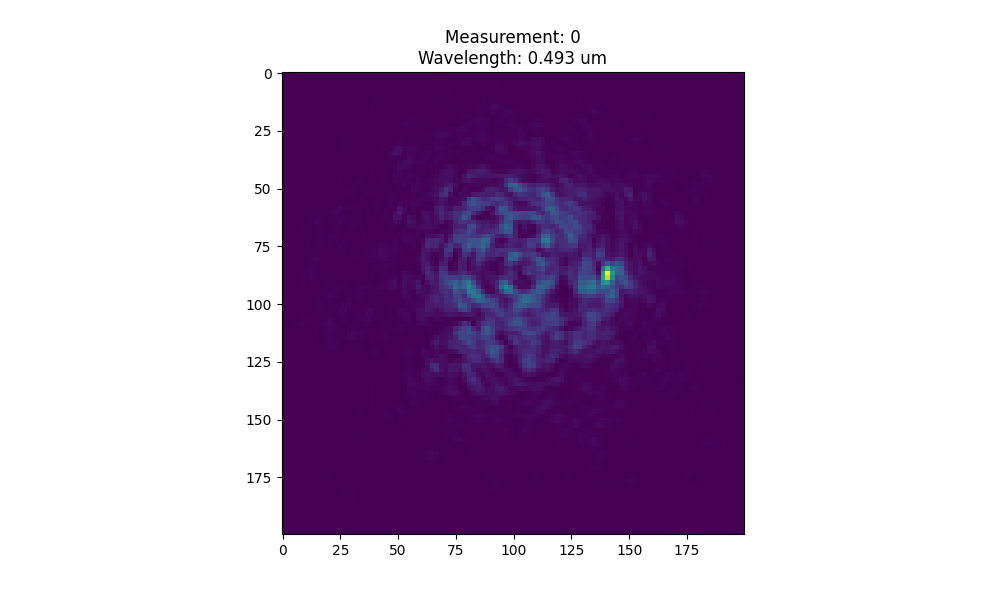

In [10]:
# ---------------------------#
# Show forward prediction
# ---------------------------#
# Show forward
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

wl_num = 0

def init():
    # img = torch.fft.fftshift(torch.abs(solver_obj.test[0]))
    # frames.append(axes.imshow(torch.abs(solver_obj.test_spherical[0])))
    frames.append(axes.imshow(forward_field_mb[wl_num,0,:,:]))
    axes.set_title('Measurement: 0\n'+'Wavelength: '+str(wl_list[0])+' um')

init()

def updateFrames(i):
    # img = torch.fft.fftshift(torch.abs(solver_obj.test_spherical[i]))
    #frames.append(axes.imshow(img))
    frames[0].set_data(torch.fft.fftshift(forward_field_mb[wl_num,i,:,:])[50:150,50:150])
    axes.set_title('Measurement: '+str(i)+'\n'+'Wavelength: '+str(wl_list[0])+' um')

interact(updateFrames, i=IntSlider(min=0, max=9, step=1, value=0))

# Affect of intial phases
## Generate the measurement with multiple random intial phases

In [24]:
# Units in microns
wavelength = 0.512  # fluorescence wavelength/um
# objective immersion media
n_measure = 1.33
# background refractive index, PDMS
n_b = 1.33
mag = 20  
pixel_size = 4
na = 0.6
dx = pixel_size / mag
dy = dx
dz = dx * 3

dtype = torch.float32
np_dtype = np.float32

na_list = sio.loadmat("na_list_3D_rand_10.mat")
fx_illu_list = na_list["na_list_3D_rand"][:, 0] * 0.5   #paraxial condition
fy_illu_list = na_list["na_list_3D_rand"][:, 1] * 0.5
fz_illu_list = na_list["na_list_3D_rand"][:, 2] * 0     #z layer at the z=0

# ---------------------------#
# Generate forward prediction with random initial phases
# ---------------------------#

num_rd_phase = 2

forward_field_mb_rd_phase = torch.zeros(num_rd_phase, len(fx_illu_list), 200, 200)
add_phase = torch.zeros(num_rd_phase, len(fx_illu_list), 200, 200)

for num in range(num_rd_phase):
    print(num)
    # initial object, type: torch.float32
    # phantom = torch.zeros((200, 200, 25), dtype=dtype)
    phantom = torch.zeros((200, 200, 25), dtype=dtype)

    # ---------------------------#
    # Setup solver objects
    # ---------------------------#
    solver_params = dict(wavelength = wavelength, na = na, \
                         RI_measure = n_measure, sigma = 2 * np.pi * dz / wavelength,\
                         fx_illu_list = fx_illu_list, fy_illu_list = fy_illu_list, fz_illu_list = fz_illu_list, \
                         voxel_size=(dy,dx,dz), pad = False, pad_size=(50,50))
    phase_obj_3d = PhaseObject3D(shape=phantom.shape, voxel_size=(dy,dx,dz), RI=n_b)
    solver_obj = Multislice(phase_obj_3d=phase_obj_3d, **solver_params)
    solver_obj.setScatteringMethod(model="MultiPhaseContrast")  # solver.obj._x set to zero

    # ---------------------------#
    # Fill in phantom
    # ---------------------------#
    # import the ground truth of the 3D object to generate forward measurements
    phantom_coordinates = sio.loadmat("phantomPoisson_nooverlap.mat")
    phantom_temp = phantom_coordinates["phantomPoisson"]
    solver_obj._x[50:150, 50:150, :] = torch.from_numpy(phantom_temp) * 0.1


    # Shift object
    for i in range(25):
        solver_obj._x[:,:,i] = torch.fft.ifftshift(solver_obj._x[:,:,i])
    
    forward_field_mb_rd_phase[num,:,:,:], fields = solver_obj.forward(obj=solver_obj._x, rd_phase=num_rd_phase)
    add_phase[num,:,:,:] = solver_obj._add_phase

0
1


interactive(children=(IntSlider(value=0, description='i', max=19), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames(i)>

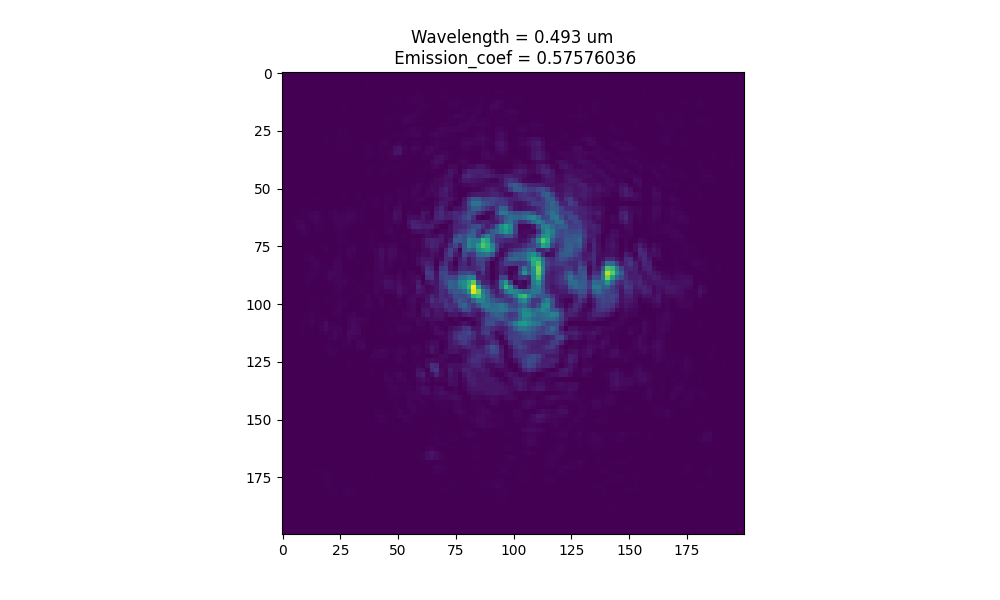

In [12]:
# ---------------------------#
# Show forward prediction
# ---------------------------#

# Show forward
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

def init():
    frames.append(axes.imshow(forward_field_mb_rd_phase[0,0,:,:]))
    axes.set_title('Wavelength = '+str(wl_list[0])+' um\n Emission_coef = '+str(wl_em_coef_list[0]))

init()

def updateFrames(i):
    frames[0].set_data(torch.fft.fftshift(forward_field_mb_rd_phase[i,0,:,:])[50:150,50:150])
    axes.set_title('Wavelength = '+str(wl_list[i])+' um\n Emission_coef = '+str(wl_em_coef_list[i]))

interact(updateFrames, i=IntSlider(min=0, max=num_rd_phase-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

<function __main__.updateFrames(i)>

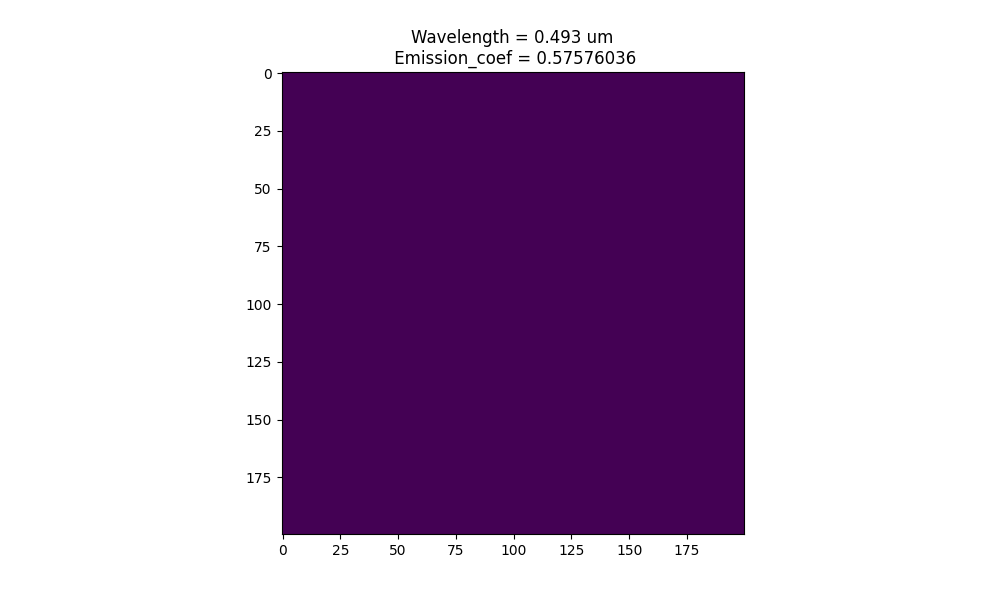

In [ ]:
# ---------------------------#
# Show forward prediction
# ---------------------------#

# Show forward
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

def init():
    frames.append(axes.imshow(add_phase[0,0,:,:]))
    axes.set_title('Wavelength = '+str(wl_list[0])+' um\n Emission_coef = '+str(wl_em_coef_list[0]))

init()

def updateFrames(i):
    frames[0].set_data(torch.fft.fftshift(add_phase[i,0,:,:]))
    axes.set_title('Wavelength = '+str(wl_list[i])+' um\n Emission_coef = '+str(wl_em_coef_list[i]))

interact(updateFrames, i=IntSlider(min=0, max=num_rd_phase-1, step=1, value=0))

# Free space propagation

interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<function __main__.updateFrames(i)>

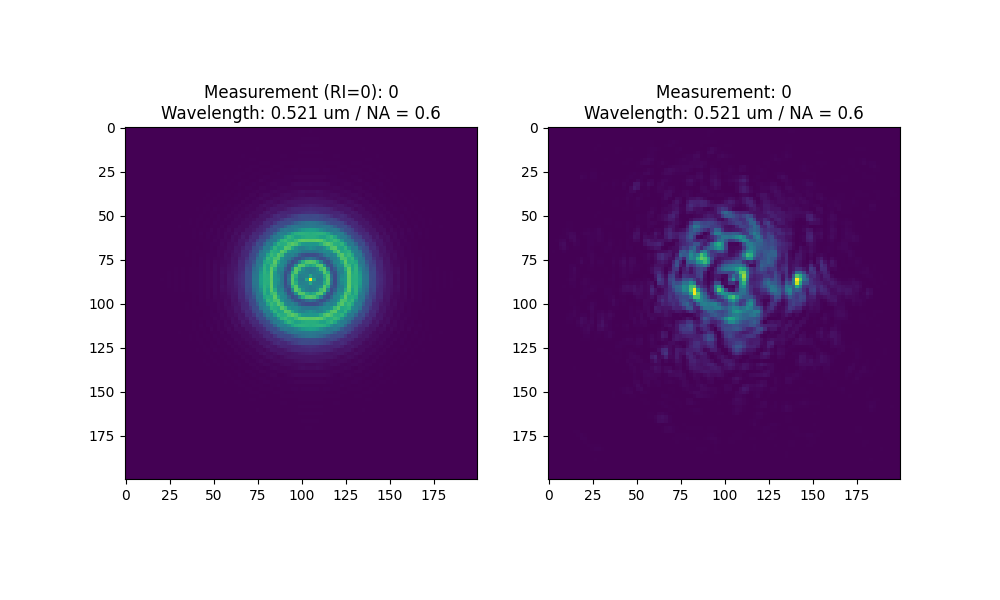

In [169]:
# Units in microns
wavelength = 0.512  # fluorescence wavelength/um
# objective immersion media
n_measure = 1.33
# background refractive index, PDMS
n_b = 1.33
mag = 20  
pixel_size = 4
na = 0.6
dx = pixel_size / mag
dy = dx
dz = dx * 3

# initial object, type: torch.float32
# phantom = torch.zeros((200, 200, 25), dtype=dtype)
phantom = torch.zeros((200, 200, 25), dtype=dtype)

# ---------------------------#
# Setup solver objects
# ---------------------------#
solver_params = dict(wavelength = wavelength, na = na, \
                     RI_measure = n_measure, sigma = 2 * np.pi * dz / wavelength,\
                     fx_illu_list = fx_illu_list, fy_illu_list = fy_illu_list, fz_illu_list = fz_illu_list, \
                     voxel_size=(dy,dx,dz), pad = False, pad_size=(50,50))
phase_obj_3d = PhaseObject3D(shape=phantom.shape, voxel_size=(dy,dx,dz), RI=n_b)
solver_obj = Multislice(phase_obj_3d=phase_obj_3d, **solver_params)
solver_obj.setScatteringMethod(model="MultiPhaseContrast")  # solver.obj._x set to zero

"""
# Show non-shifted objects
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

def init():
    frames.append(axes.imshow(torch.fft.fftshift(solver_obj._x[:, :, 0])))
    axes.set_title('filled in phantom')

init()

def updateFrames(i):
    frames[0].set_data(torch.fft.fftshift(solver_obj._x[:, :, i]))

interact(updateFrames, i=IntSlider(min=0, max=24, step=1, value=0))
"""

# ---------------------------#
# Generate forward prediction
# ---------------------------#
forward_field_mb_free, fields = solver_obj.forward(obj=solver_obj._x)

# ---------------------------#
# Show forward prediction
# ---------------------------#

# Show forward
f, axes = plt.subplots(1, 2, figsize=(10, 6))
frames = []

def init():
    frames.append(axes[0].imshow(forward_field_mb_free[0]))
    frames.append(axes[1].imshow(forward_field_mb[wl_num,0,:,:]))
    axes[0].set_title('Measurement (RI=0): 0\n'+'Wavelength: 0.521 um / NA = 0.6')
    axes[1].set_title('Measurement: 0\n'+'Wavelength: 0.521 um / NA = 0.6')

init()

def updateFrames(i):
    frames[0].set_data(torch.fft.fftshift(forward_field_mb_free[i])[50:150,50:150])
    axes[0].set_title('Measurement (RI=0): '+str(i)+'\n'+'Wavelength: 0.521 um / NA = 0.6')
    frames[1].set_data(torch.fft.fftshift(forward_field_mb[wl_num,i,:,:])[50:150,50:150])
    axes[1].set_title('Measurement: '+str(i)+'\n'+'Wavelength: 0.521 um / NA = 0.6')

interact(updateFrames, i=IntSlider(min=0, max=9, step=1, value=0))

# Sampling affects the results

In [ ]:
# Units in microns
wavelength = 0.512  # fluorescence wavelength/um
# objective immersion media
n_measure = 1.33
# background refractive index, PDMS
n_b = 1.33
mag = 20  
pixel_size = 4
na = 0.6
dx = pixel_size / mag
dy = dx
dz = dx * 3

# initial object, type: torch.float32
# phantom = torch.zeros((200, 200, 25), dtype=dtype)
phantom = torch.zeros((200, 200, 25), dtype=dtype)

# ---------------------------#
# Setup solver objects
# ---------------------------#
solver_params = dict(wavelength = wavelength, na = na, \
                     RI_measure = n_measure, sigma = 2 * np.pi * dz / wavelength,\
                     fx_illu_list = fx_illu_list, fy_illu_list = fy_illu_list, fz_illu_list = fz_illu_list, \
                     voxel_size=(dy,dx,dz), pad = False, pad_size=(50,50))
phase_obj_3d = PhaseObject3D(shape=phantom.shape, voxel_size=(dy,dx,dz), RI=n_b)
solver_obj = Multislice(phase_obj_3d=phase_obj_3d, **solver_params)
solver_obj.setScatteringMethod(model="MultiPhaseContrast")  # solver.obj._x set to zero

"""
# Show non-shifted objects
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

def init():
    frames.append(axes.imshow(torch.fft.fftshift(solver_obj._x[:, :, 0])))
    axes.set_title('filled in phantom')

init()

def updateFrames(i):
    frames[0].set_data(torch.fft.fftshift(solver_obj._x[:, :, i]))

interact(updateFrames, i=IntSlider(min=0, max=24, step=1, value=0))
"""

# ---------------------------#
# Generate forward prediction
# ---------------------------#
forward_field_mb, fields = solver_obj.forward(obj=solver_obj._x)

# ---------------------------#
# Show forward prediction
# ---------------------------#

# Show forward
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

def init():
    frames.append(axes.imshow(forward_field_mb[0]))
    axes.set_title('Measurement: 0\n'+'Wavelength: 0.521 um / NA = 0.6')

init()

def updateFrames(i):
    frames[0].set_data(torch.fft.fftshift(forward_field_mb[i])[50:150,50:150])
    axes.set_title('Measurement: '+str(i)+'\n'+'Wavelength: 0.521 um / NA = 0.6')

interact(updateFrames, i=IntSlider(min=0, max=9, step=1, value=0))